In [400]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [2]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [50]:
[num_info, cat_info, date_info] = [func.get_station_info(f) for f in const.TRAIN_FILES]

# Date features refer to numeric/categorical features
date_info['ref_feat_nr'] = date_info['feature_nr'] - 1

In [366]:
num_data = func.load_data_file(const.TRAIN_FILES[0])
date_data = func.load_data_file(const.TRAIN_FILES[2])
cat_data = func.load_data_file(const.TRAIN_FILES[1])

Returning <open file '/Volumes/My Book/kaggle_bosch/train_numeric.pkl', mode 'rb' at 0x116717b70>
Returning <open file '/Volumes/My Book/kaggle_bosch/train_date.pkl', mode 'rb' at 0x116717b70>
Returning <open file '/Volumes/My Book/kaggle_bosch/train_categorical_to_num.pkl', mode 'rb' at 0x116717b70>


In [352]:
#del num_data, date_data, cat_data

In [351]:
ids = num_data['data']['ids']
y = num_data['data']['y']

In [57]:
date_info.head()

,line,station,feature_nr,name,ref_feat_nr
0,0,0,1,L0_S0_D1,0
1,0,0,3,L0_S0_D3,2
2,0,0,5,L0_S0_D5,4
3,0,0,7,L0_S0_D7,6
4,0,0,9,L0_S0_D9,8


In [299]:
# Load 
date_lut = pd.read_csv('./data/date_col_lookup_table.csv', index_col='date_col_n')
date_lut.head()

,col_nr,feature_type
date_col_n,,
0,0,numeric
1,1,numeric
2,2,numeric
3,3,numeric
4,4,numeric


In [318]:
date_lut.feature_type.value_counts()

categorical    759
numeric        366
unknown         31
Name: feature_type, dtype: int64

## Get a better idea of how much data per sample

In [5]:
row_nonzeros_num = np.diff(num_data['data']['features'].indptr)
row_nonzeros_cat = np.diff(cat_data['data']['features'].indptr)

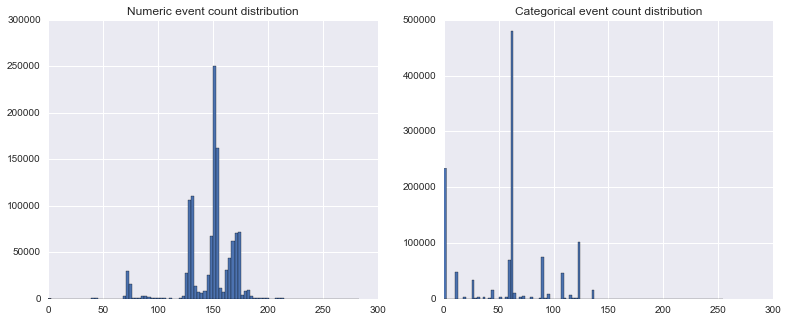

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
ax1.hist(row_nonzeros_num, bins=100)
ax2.hist(row_nonzeros_cat, bins=100)
ax1.set_title('Numeric event count distribution')
ax2.set_title('Categorical event count distribution')

## Visualize one product

This analysis can be really messy, because each sample:
- Between 0 and 300 categorical features
- Between 0 and 300 numeric features
- Less or more timestamp features
To simplify and start easy collect per sample:
- Number of categorical features
- Number of numeric features
- Number of timestamp features
- Number of categorical features with a timestamp
- Number of numeric features with a timestamp

In [163]:
pid=107

In [164]:
prod_ids = num_data['data']['ids']
sample_nr = prod_ids[prod_ids.Id==pid].index.values[0]

In [371]:
def collect_sample_info(x):
    sample_nr = x.name
    
    # Collect data from three datasets
    num_mea = num_data['data']['features'][sample_nr,:]
    dat_mea = date_data['data']['features'][sample_nr,:]
    cat_mea = cat_data['data']['features'][sample_nr,:]
    
    # Get indices of non-zero elements
    # This goes wrong with sparse dataset if values are zero!!!
    # TO-DO: REDO ON DENSE DATASETS
    n_col_num = num_mea.nonzero()[1] # column indices of non zero elements
    n_col_cat = cat_mea.nonzero()[1] # column indices of non zero elements
    n_col_dat = dat_mea.nonzero()[1] # column indices of non zero elements
    
    # Get date column indices from numeric/categoric indices
    #n_col_num_t = pd.Series([date_col_lot_num[n] for n in n_col_num])
    #n_col_cat_t = pd.Series([date_col_lot_cat[n] for n in n_col_cat])
    feat_types_count = date_lut[date_lut.index.isin(n_col_dat)].feature_type.value_counts()
    
    cat_count = feat_types_count['categorical'] if 'categorical' in feat_types_count.index else 0
    num_count = feat_types_count['numeric'] if 'numeric' in feat_types_count.index else 0
    unk_count = feat_types_count['unknown'] if 'unknown' in feat_types_count.index else 0
    
    # Get some info on timing
    tmin = -1
    tmax = -1
    if len(n_col_dat)>0:
        t = [dat_mea[0,n] for n in n_col_dat]
        tmin = min(t)
        tmax = max(t)
    
    #
    output = {'id': sample_nr,
              'n_numeric': n_col_num.shape[0],
              'n_categorical': n_col_cat.shape[0],
              'n_timestamp': n_col_dat.shape[0],
              'n_numeric_t': num_count,
              'n_categorical_t': cat_count,
              'n_unknown': unk_count,
              't_min': tmin,
              't_max': tmax}
    
    return pd.Series(output)

In [372]:
prod_info = prod_ids.apply(lambda x: collect_sample_info(x), axis=1)

In [373]:
prod_info['Response'] = y.values
prod_info['t_delta'] = prod_info['t_max'] - prod_info['t_min']

In [374]:
prod_info.head(10)

,id,n_categorical,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,t_max,t_min,Response,t_delta
0,0.0,0.0,83.0,133.0,91.0,179.0,5.0,87.290001,82.239998,0,5.050003
1,1.0,0.0,116.0,154.0,90.0,209.0,3.0,1315.750000,1313.119995,0,2.630005
2,2.0,63.0,114.0,150.0,90.0,207.0,3.0,1624.420044,1618.699951,0,5.720093
3,3.0,63.0,109.0,152.0,93.0,207.0,5.0,1154.160034,1149.199951,0,4.960083
4,4.0,63.0,109.0,151.0,93.0,207.0,5.0,606.020020,602.640015,0,3.380005
5,5.0,63.0,109.0,151.0,93.0,207.0,5.0,1339.729980,1331.660034,0,8.069946
6,6.0,63.0,100.0,153.0,104.0,209.0,5.0,1664.040039,1662.630005,0,1.410034
7,7.0,122.0,127.0,174.0,118.0,249.0,4.0,804.359985,791.219971,0,13.140015
8,8.0,63.0,77.0,131.0,93.0,175.0,5.0,518.080017,517.640015,0,0.440002
9,9.0,63.0,82.0,132.0,92.0,177.0,3.0,157.889999,156.270004,0,1.619995


In [375]:
# Samples with Response 1 have very similar properties as samples with Response 0, no clues here...
# They have more categorical test (on average 5%...)
# Average time spend on all three lines is different
prod_info.groupby('Response').mean()

,id,n_categorical,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,t_max,t_min,t_delta
Response,,,,,,,,,,
0,591866.131374,57.124088,105.906170,147.278363,95.268681,205.261021,4.086169,859.205175,848.510707,10.694468
1,593048.093182,61.553423,106.740369,147.878471,95.051316,205.733537,3.941852,774.026250,760.116118,13.910132


In [377]:
prod_info[prod_info.t_delta>0].groupby('Response').mean()

,id,n_categorical,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,t_max,t_min,t_delta
Response,,,,,,,,,,
0,591919.996895,57.158085,105.969137,147.365711,95.325024,205.382750,4.088589,859.631647,848.930814,10.700833
1,593140.058892,61.571325,106.771412,147.921477,95.078959,205.793369,3.942998,774.251647,760.337470,13.914177


In [391]:
prod_info[prod_info.t_delta>100].groupby('Response').mean()

,id,n_categorical,n_categorical_t,n_numeric,n_numeric_t,n_timestamp,n_unknown,t_max,t_min,t_delta
Response,,,,,,,,,,
0,613614.791885,82.945462,130.121728,166.094677,100.068063,234.139616,3.949825,912.474698,722.152687,190.322011
1,598362.645161,90.645161,126.612903,161.129032,98.645161,228.967742,3.709677,955.348387,755.482585,199.865801


In [346]:
prod_info.n_unknown.value_counts()

3     429173
5     425482
4     132175
2     104359
7      55674
9      26476
6       5379
8       2130
1       1667
0        806
11       272
10        86
12        68
Name: n_unknown, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x20f1edd50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x227fb9c10>], dtype=object)

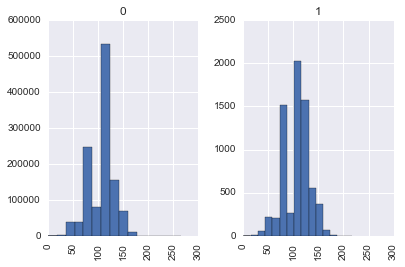

In [394]:
# There seems to be a cluster of products with around 75 categorical features...
prod_info.hist('n_categorical_t',by='Response', sharex=True, bins=15)

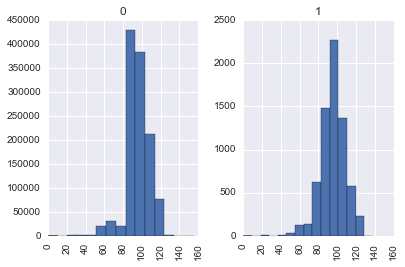

In [387]:
prod_info.hist('n_numeric_t',by='Response', sharex=True, bins=15)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x287a23dd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x27c947f90>], dtype=object)

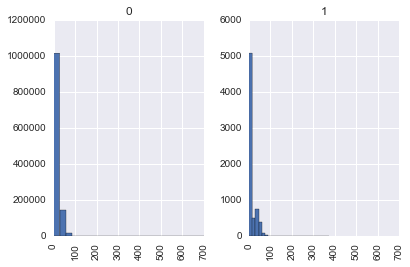

In [393]:
prod_info.hist('t_delta',by='Response', sharex=True, bins=25)

In [402]:
str(datetime.datetime.now())

'2016-09-24 10:16:47.238378'

In [406]:
column_info = {'id': 'product id',
               'n_categorical_t': 'number of categorical features with a timestamp',
             'n_numeric_t': 'number of numeric features with a timestamp',
              'n_timestamp': 'number of timestamp features',
              'n_unknown': 'number of timestamp features without categorical or numeric counterpart',
              't_max': 'highest timestamp value',
               't_min':'lowest timestamp value',
               'Response': 'Response column from numeric',
               't_delta': 't_max-t_min'}

meta = {'created_by': 'joostgp',
        'created_at': str(datetime.datetime.now()),
        'script': 'eda_product_view.ipnb',
        'description': column_info}

In [398]:
prod_info.drop(['n_numeric','n_categorical'], axis=1). \
    to_csv(os.path.join(const.DATA_PATH,'eda_prod_info.csv'), index=False)


In [407]:
with open(os.path.join(const.DATA_PATH, 'eda_prod_info.log'),'w') as f:

    for (key, value) in meta.iteritems():
        f.write('[{}]\n'.format(key))
        if isi
        f.write('{}\n'.format(value))
        f.write('\n')